# 4.Final Modeling

**Purpose:** Apply final trained models (LightGBM & XGBoost) to the test set, generate predictions, evaluate performance, and save results.  

Contents:
1. **Import Libraries**  
   Load all necessary Python packages for data manipulation, modeling, evaluation, and visualization.

2. **Load Test Data**  
   Load and preprocess the test dataset, ensuring feature alignment with the trained models.

3. **Define Features and Target**  
   Identify feature columns and target column (`value`) for prediction.

4. **Load Final Models**  
   Load LightGBM and XGBoost models saved from final training.

5. **Make Predictions**  
   Apply the loaded models to the test set to generate predictions.

6. **Evaluate Performance (Optional)**  
   If target values are available in test data, compute RMSE, MAE, and R² score.

7. **Save Predictions**  
   Save the prediction results in CSV (or any preferred format) for further use or submission.

8. **Visualize Predictions (Optional)**  
   Compare actual vs predicted values via plots for sanity check and reporting.


## 4.1 Import Libraries

In [21]:
# -------------------------------
# IMPORT LIBRARIES
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as lgb
import xgboost as xgb
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 4.2 Load Dataset

In [22]:
# -------------------------------
# LOAD TEST DATA
# -------------------------------
# Load processed test set (after feature engineering)
# Note: This test set should already include all lag/rolling features
test_df = pd.read_csv("../data/modeling/test.csv", parse_dates=["timestamp"])

# Inspect
display(test_df.head())
print(test_df.info())

,series_id,timestamp,value,hour,dayofweek,day,month,is_weekend,lag_1,lag_4,lag_96,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,Solar5,2020-11-01,23.73,0,6,1,11,1,23.01,17.11,9.66,14.44,9.33,3.05,102398.77,0.71,497.65,355.39,0.94
1,Solar0,2020-11-01,32.02,0,6,1,11,1,31.90,23.39,12.19,14.44,9.33,3.05,102398.77,0.71,497.65,355.39,0.94
2,Solar4,2020-11-01,5.01,0,6,1,11,1,5.13,3.62,1.86,14.44,9.33,3.05,102398.77,0.71,497.65,355.39,0.94
3,Solar1,2020-11-01,8.51,0,6,1,11,1,7.95,6.31,3.17,14.44,9.33,3.05,102398.77,0.71,497.65,355.39,0.94
4,Solar3,2020-11-01,7.52,0,6,1,11,1,7.69,5.45,2.96,14.44,9.33,3.05,102398.77,0.71,497.65,355.39,0.94


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22956 entries, 0 to 22955
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   series_id                          22956 non-null  object        
 1   timestamp                          22956 non-null  datetime64[ns]
 2   value                              22956 non-null  float64       
 3   hour                               22956 non-null  int64         
 4   dayofweek                          22956 non-null  int64         
 5   day                                22956 non-null  int64         
 6   month                              22956 non-null  int64         
 7   is_weekend                         22956 non-null  int64         
 8   lag_1                              22956 non-null  float64       
 9   lag_4                              22956 non-null  float64       
 10  lag_96                            

## 4.3 Define Features & Target

In [23]:
# -------------------------------
# DEFINE FEATURES AND TARGET
# -------------------------------
# Features are all columns except 'series_id', 'timestamp', and 'value'
# Target is 'value' (if available for validation)

target_col = "value"
feature_cols = [col for col in test_df.columns if col not in ["timestamp", "value", "series_id"]]

X_test = test_df[feature_cols]

# If test labels are available for validation purposes
y_test = test_df.get("value")  # Will be None if not available

print(f"Number of features: {len(feature_cols)}")

Number of features: 16


## 4.4 Load Final Model

In [24]:
# -------------------------------
# LOAD FINAL MODELS
# -------------------------------

# --- LightGBM ---
lgb_model = lgb.Booster(model_file="../models/lgb_model.txt")  # Load core API booster

# --- XGBoost ---
xgb_model = xgb.Booster()
xgb_model.load_model("../models/xgb_model.json")

## 4.5 Predictions

In [25]:
# -------------------------------
# PREDICTION
# -------------------------------

# --- LightGBM prediction ---
lgb_pred = lgb_model.predict(X_test)
# Core API requires numpy array or dataframe

# --- XGBoost prediction ---
# Core API requires DMatrix
dtest = xgb.DMatrix(X_test)
xgb_pred = xgb_model.predict(dtest)

## 4.5 Evaluate Performance

In [26]:
# -------------------------------
# VALUATE PERFORMANCE (if target exists)
# -------------------------------
if y_test is not None:
    # LightGBM metrics
    lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
    lgb_mae = mean_absolute_error(y_test, lgb_pred)
    lgb_r2 = r2_score(y_test, lgb_pred)

    print("=== LightGBM Performance on Test ===")
    print(f"RMSE: {lgb_rmse:.4f}")
    print(f"MAE: {lgb_mae:.4f}")
    print(f"R² Score: {lgb_r2:.4f}\n")

    # XGBoost metrics
    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
    xgb_mae = mean_absolute_error(y_test, xgb_pred)
    xgb_r2 = r2_score(y_test, xgb_pred)

    print("=== XGBoost Performance on Test ===")
    print(f"RMSE: {xgb_rmse:.4f}")
    print(f"MAE: {xgb_mae:.4f}")
    print(f"R² Score: {xgb_r2:.4f}\n")
else:
    print("Target not available in test set. Only predictions will be saved.")

=== LightGBM Performance on Test ===
RMSE: 18.3777
MAE: 4.3392
R² Score: 0.9833

=== XGBoost Performance on Test ===
RMSE: 16.9525
MAE: 3.3279
R² Score: 0.9858



## 4.6 Save Predictions

In [27]:
# -------------------------------
# Save Predictions
# -------------------------------
# Combine results into one DataFrame
pred_df = pd.DataFrame({
    "series_id": test_df["series_id"],
    "timestamp": test_df["timestamp"],
    "value_lgb": lgb_pred,
    "value_xgb": xgb_pred
})

# Save to CSV
pred_df.to_csv("../results/test_predictions.csv", index=False)
print("Predictions saved to '../results/test_predictions.csv'.")

Predictions saved to '../results/test_predictions.csv'.


## 4.7 Visualize Predictions

#### 4.7.1 Metrics comparison
Perbandingan RMSE, MAE, dan R² antar model dalam bentuk bar chart.

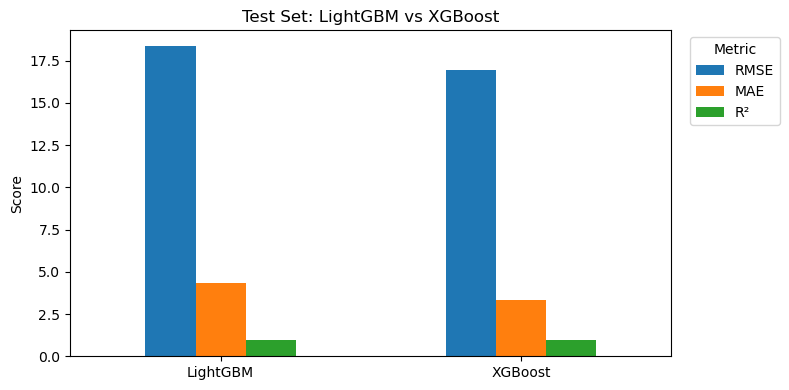

In [28]:
# Bar chart: metrics comparison (only when target available)
if y_test is not None:
    metrics_df = pd.DataFrame({
        "LightGBM": [lgb_rmse, lgb_mae, lgb_r2],
        "XGBoost": [xgb_rmse, xgb_mae, xgb_r2]
    }, index=["RMSE", "MAE", "R²"])
    metrics_df.T.plot(kind="bar", figsize=(8, 4), rot=0)
    plt.title("Test Set: LightGBM vs XGBoost")
    plt.ylabel("Score")
    plt.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig("../results/figures/final/metrics_comparison.png", dpi=150, bbox_inches="tight")
    plt.show()

#### 4.7.2 Actual vs predicted (scatter)
Scatter plot dengan garis y=x: titik ideal mengikuti diagonal; penyebaran menunjukkan besarnya error.

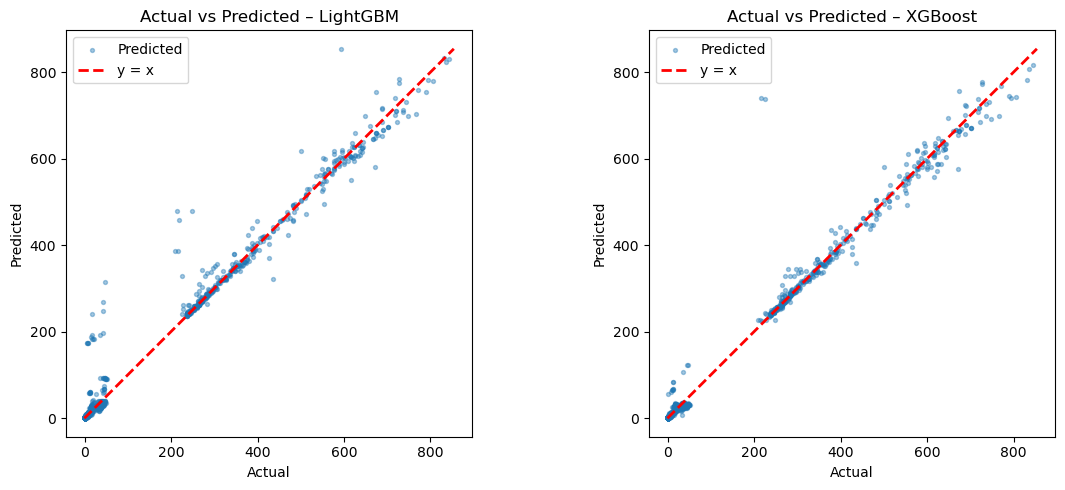

In [29]:
# Scatter actual vs predicted + y=x diagonal (subsample if too many points)
if y_test is not None:
    y_a, pred_lgb, pred_xgb = np.asarray(y_test), np.asarray(lgb_pred), np.asarray(xgb_pred)
    n_show = min(3000, len(y_a))
    idx = np.random.default_rng(42).choice(len(y_a), size=n_show, replace=False)
    mi, ma = min(y_a.min(), pred_lgb.min(), pred_xgb.min()), max(y_a.max(), pred_lgb.max(), pred_xgb.max())
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax, pred, name in zip(axes, [pred_lgb, pred_xgb], ["LightGBM", "XGBoost"]):
        ax.scatter(y_a[idx], pred[idx], alpha=0.4, s=8, label="Predicted")
        ax.plot([mi, ma], [mi, ma], "r--", lw=2, label="y = x")
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted")
        ax.set_title(f"Actual vs Predicted – {name}")
        ax.legend()
        ax.set_aspect("equal")
    plt.tight_layout()
    plt.savefig("../results/figures/final/scatter_actual_vs_predicted.png", dpi=150, bbox_inches="tight")
    plt.show()

#### 4.7.3 Residuals analysis
Histogram residual dan residual vs predicted untuk cek bias dan heteroskedastisitas.

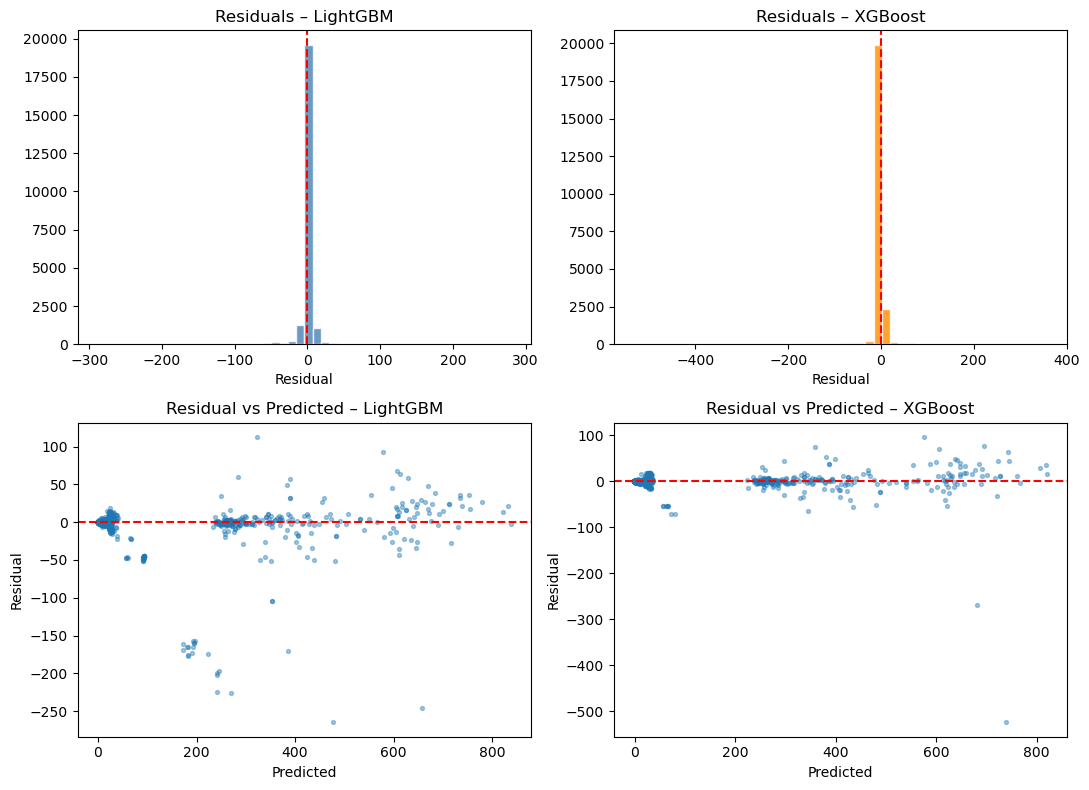

In [30]:
# Residuals: histogram and residuals vs predicted
if y_test is not None:
    res_lgb = np.asarray(y_test) - np.asarray(lgb_pred)
    res_xgb = np.asarray(y_test) - np.asarray(xgb_pred)
    fig, axes = plt.subplots(2, 2, figsize=(11, 8))
    # Histograms
    axes[0, 0].hist(res_lgb, bins=50, color="steelblue", alpha=0.8, edgecolor="white")
    axes[0, 0].axvline(0, color="red", linestyle="--")
    axes[0, 0].set_title("Residuals – LightGBM")
    axes[0, 0].set_xlabel("Residual")
    axes[0, 1].hist(res_xgb, bins=50, color="darkorange", alpha=0.8, edgecolor="white")
    axes[0, 1].axvline(0, color="red", linestyle="--")
    axes[0, 1].set_title("Residuals – XGBoost")
    axes[0, 1].set_xlabel("Residual")
    # Residual vs predicted
    n_show = min(2000, len(res_lgb))
    i = np.random.default_rng(43).choice(len(res_lgb), size=n_show, replace=False)
    axes[1, 0].scatter(lgb_pred[i], res_lgb[i], alpha=0.4, s=8)
    axes[1, 0].axhline(0, color="red", linestyle="--")
    axes[1, 0].set_xlabel("Predicted")
    axes[1, 0].set_ylabel("Residual")
    axes[1, 0].set_title("Residual vs Predicted – LightGBM")
    axes[1, 1].scatter(xgb_pred[i], res_xgb[i], alpha=0.4, s=8)
    axes[1, 1].axhline(0, color="red", linestyle="--")
    axes[1, 1].set_xlabel("Predicted")
    axes[1, 1].set_ylabel("Residual")
    axes[1, 1].set_title("Residual vs Predicted – XGBoost")
    plt.tight_layout()
    plt.savefig("../results/figures/final/residuals_analysis.png", dpi=150, bbox_inches="tight")
    plt.show()

#### 4.7.4 Error by series
Distribusi absolute error per `series_id` untuk melihat series mana yang paling sulit diprediksi.

/tmp/ipykernel_35835/2567204277.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=err_df, x="series_id", y=col, order=order, ax=ax, palette="viridis")
/tmp/ipykernel_35835/2567204277.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=err_df, x="series_id", y=col, order=order, ax=ax, palette="viridis")


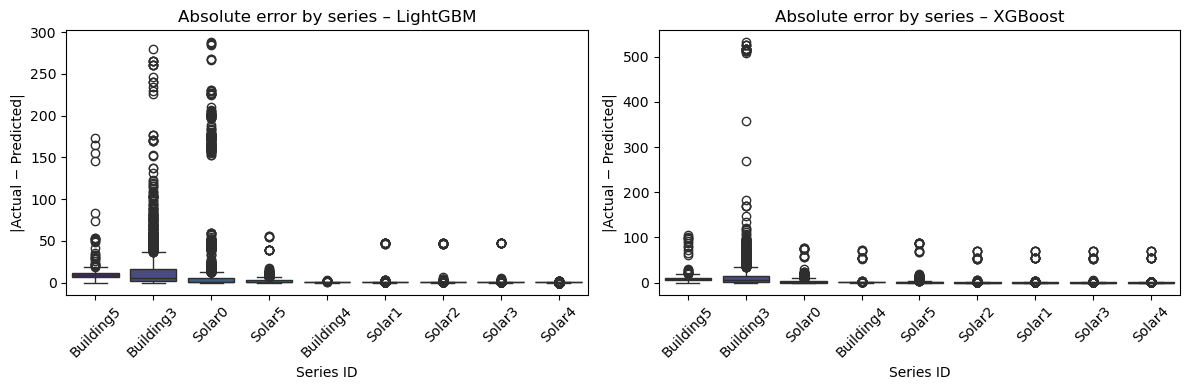

In [31]:
# Absolute error by series_id (when test has multiple series and labels exist)
if y_test is not None and "series_id" in test_df.columns:
    import seaborn as sns
    err_df = pd.DataFrame({
        "series_id": test_df["series_id"].values,
        "abs_err_lgb": np.abs(np.asarray(y_test) - np.asarray(lgb_pred)),
        "abs_err_xgb": np.abs(np.asarray(y_test) - np.asarray(xgb_pred)),
    })
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for ax, col, name in zip(axes, ["abs_err_lgb", "abs_err_xgb"], ["LightGBM", "XGBoost"]):
        order = err_df.groupby("series_id")[col].median().sort_values(ascending=False).index.tolist()
        sns.boxplot(data=err_df, x="series_id", y=col, order=order, ax=ax, palette="viridis")
        ax.set_title(f"Absolute error by series – {name}")
        ax.set_xlabel("Series ID")
        ax.set_ylabel("|Actual − Predicted|")
        ax.tick_params(axis="x", rotation=45)
    plt.tight_layout()
    plt.savefig("../results/figures/final/error_by_series.png", dpi=150, bbox_inches="tight")
    plt.show()

## 4.8 Key Insigth

LightGBM:
- **RMSE:** 18.3777  
- **MAE:** 4.3392  
- **R² Score:** 0.9833  

XGBoost:
- **RMSE:** 16.9525  
- **MAE:** 3.3279  
- **R² Score:** 0.9858  

Interpretation:
- Both models show **high accuracy** and explain over 98% of variance in the test set.  
- **XGBoost performs slightly better** in all metrics, especially MAE.  
- RMSE represents the **average magnitude of large errors**, while MAE represents the **average absolute error**.  
- In context: target values ~1300 → MAE of 3–4 and RMSE ~17 is **very small**, indicating the model predictions are very close to actual values.  

Deployment Recommendation:
- **Option 1:** Deploy only **XGBoost** (highest performance) for simplicity.  
- **Option 2:** Save both **LightGBM & XGBoost** for ensemble or comparative analysis.